In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
X_train = pd.read_csv("hw11t5v3_train.txt", sep="\t", header=None)
print X_train.shape
X_train.head()

(500, 3)


,0,1,2
0,0.895,-2.873,0.504
1,2.856,0.168,1.951
2,-0.576,-0.238,-0.437
3,-0.277,0.205,-0.218
4,3.494,-0.137,1.955


In [3]:
X_test = pd.read_csv("hw11t5v3_test.txt", sep="\t", header=None)
print X_test.shape
X_test.head()

(50, 3)


,0,1,2
0,2.106,0.760,1.731
1,0.108,0.010,0.907
2,-2.145,-2.176,0.975
3,2.733,0.914,1.373
4,1.493,-3.425,1.007


In [4]:
y_train = pd.read_csv("hw11t5v3_target.txt", sep="\t", header=None)
y_test = pd.read_csv("hw11t5v3_target_test.txt", sep="\t", header=None)

Изобразим обучающую выборку.

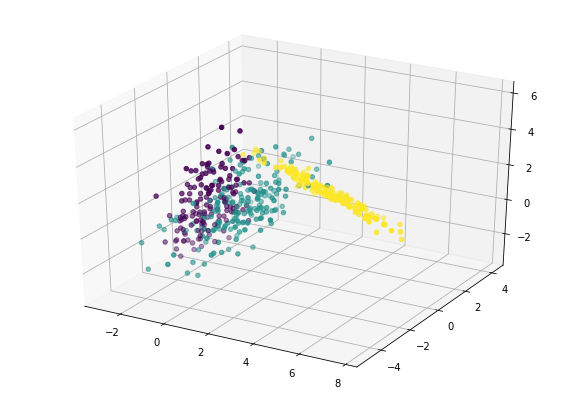

In [5]:
plt.close()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train.values[:,0], X_train.values[:,1], X_train.values[:,2], c=y_train)
plt.show()

Видно как минимум 2 кластера, имеющие, каждый в отдельности, хороший отклик с меткой.

Изобразим проекции обучающей выборки на 1 и 2-мерные пространства.

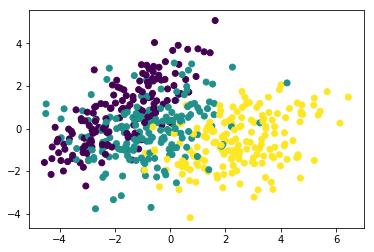

In [6]:
pca = PCA(n_components=2)
X_train_transformed = pca.fit_transform(X_train)
plt.scatter(X_train_transformed[:,0], X_train_transformed[:,1], c=y_train)
plt.show()

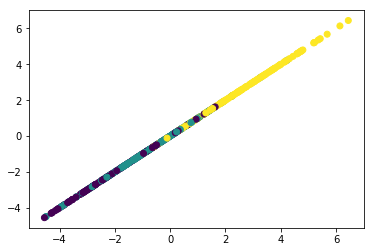

In [7]:
pca = PCA(n_components=1)
X_train_transformed = pca.fit_transform(X_train)
plt.scatter(X_train_transformed, X_train_transformed, c=y_train)
plt.show()

При проецировании на 1 и 2 компоненты кластеры смешиваются, но метка остаётся разделимой.

Попробуем нелинейное преобразование.

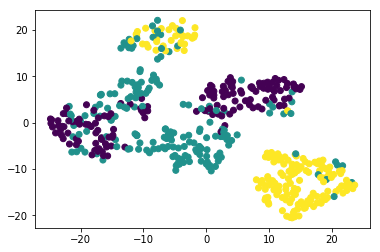

In [9]:
tsne = TSNE(n_components=2)
X_train_transformed = tsne.fit_transform(X_train)
plt.scatter(X_train_transformed[:,0], X_train_transformed[:,1], c=y_train)
plt.show()

В 2-мерном пространстве появилось что-то похожее на кластеры, которые к тому же хорошо откликаются на метку.

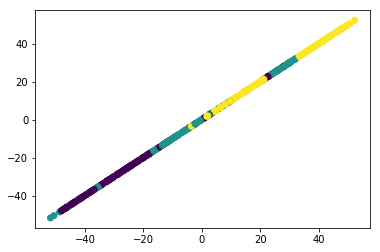

In [10]:
tsne = TSNE(n_components=1)
X_train_transformed = tsne.fit_transform(X_train)
plt.scatter(X_train_transformed, X_train_transformed, c=y_train)
plt.show()

В 1-мерном пространстве нет кластеров и метка линейно не разделима.

Протестируем модель, обученную на исходной выборке.

In [11]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
print accuracy_score(y_test, y_predicted)

0.88


/home/ilivans/.virtualenvs/cmn/local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)

print accuracy_score(y_test, y_predicted)

0.9


/home/ilivans/.virtualenvs/cmn/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Теперь спроецируем выборку и обучим kNN.

In [14]:
def train_and_eval(reducer):
    if isinstance(reducer, PCA):
        X_train_transformed = reducer.fit_transform(X_train)
        X_test_transformed = reducer.transform(X_test)
    elif isinstance(reducer, TSNE):
        X_transformed = reducer.fit_transform(np.vstack((X_train, X_test)))
        X_train_transformed = X_transformed[:X_train.shape[0]]
        X_test_transformed = X_transformed[X_train.shape[0]:]
    else:
        raise ValueError("Unknown reducer " + str(reducer.__class__))

    knn = KNeighborsClassifier()
    knn.fit(X_train_transformed, y_train)
    y_predicted = knn.predict(X_test_transformed)

    return accuracy_score(y_test, y_predicted)
    
print train_and_eval(PCA(n_components=2))
print train_and_eval(PCA(n_components=1))
print train_and_eval(TSNE(n_components=2))
print train_and_eval(PCA(n_components=1))

/home/ilivans/.virtualenvs/cmn/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]


0.64
0.56
0.92
0.56


Как видим, accuracy стремительно падает при переходе в пространство меньшей размерности. Только TSNE при проекции в 2-мерное пространство позволяет сохранить достаточно информации для сохранения качества классификации.

Это говорит о слабой мультиколлинеарности и отсутствии необходимости в уменьшении размерности.

In [15]:
from sklearn.svm import SVC
regressor = SVC()
regressor.fit(X_train, y_train)
y_predicted = regressor.predict(X_test)
print accuracy_score(y_test, y_predicted)

0.96
